# 5. ELAIS-N1 Luminosity Function with xid_sample

In this notebook we look at a sample of all objects with any xid+ flux. This removes the effects of selecting only objects with 2 or more 'good' xid+ fluxes.

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))
import datetime
print("This notebook was executed on: \n{}".format(datetime.datetime.now()))

This notebook was run with herschelhelp_internal version: 
1407877 (Mon Feb 4 12:56:29 2019 +0000)
This notebook was executed on: 
2019-06-05 17:04:13.504353


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

import os
import time
import glob

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table, join
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import Planck15
from astropy.cosmology import z_at_value
from astropy.constants import iau2015 as const
Lsun= const.L_sun.value

import numpy as np
from pymoc import MOC
import healpy as hp
#import pandas as pd #Astropy has group_by function so apandas isn't required.
import seaborn as sns

import warnings
#We ignore warnings - this is a little dangerous but a huge number of warnings are generated by empty cells later
warnings.filterwarnings('ignore')

from herschelhelp_internal.utils import inMoc, coords_to_hpidx, flux_to_mag, mag_to_flux
from herschelhelp_internal.masterlist import find_last_ml_suffix, nb_ccplots

from astropy.io.votable import parse_single_table

from pcigale.sed import SED
from pcigale.sed_modules import get_module

from lf.lf import plot_LF, volume

In [3]:
#os.environ['GAMA_DATA'] = 'We are not using GAMA data'
#from luminosity_function.gal_sample import CosmoLookup

In [4]:
FIELD = 'ELAIS-N1'
#FILTERS_DIR = "/opt/herschelhelp_python/database_builder/filters/"
#DMU_DIR = '/mnt/hedam/dmu_products/'
DMU_DIR = '/Users/rs548/GitHub/dmu_products/'

In [5]:
#depths = Table.read("{}dmu1/dmu1_ml_ELAIS-N1/data/depths_elais-n1_20180216.fits".format(DMU_DIR))
#final_cat = Table.read("{}dmu32/dmu32_ELAIS-N1/data/ELAIS-N1_20171016.fits".format(DMU_DIR))
servs_moc = 'EMPTY'

## I - Histogram of areas


In [6]:
#Made a small subcat with: 
#stilts tpipe cmd='keepcols "help_id ra dec f_irac_i1 f_irac_i2 f_irac_i3 f_irac_i4 f_mips_24 
#flag_optnir_det redshift cigale_dustlumin"' ELAIS-N1_20171016.fits omode=out out=cut_for_lf.fits
catalogue = Table.read(DMU_DIR + 'dmu32/dmu32_ELAIS-N1/data/'
                       +'cut_for_lf.fits')['help_id',
                                           'ra', 
                                           'dec', 
                                           'f_irac_i1', 
                                           'f_mips_24',
                                           'redshift', 
                                           'cigale_dustlumin'] #ELAIS-N1_20171016.fits
    

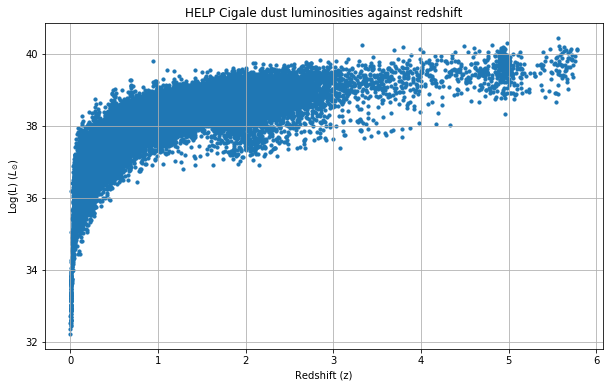

In [7]:
plt.figure(figsize=(10,6))
plt.scatter(catalogue['redshift'],np.log10(catalogue['cigale_dustlumin']), s = 10)
plt.title('HELP Cigale dust luminosities against redshift')
plt.xlabel('Redshift (z)')
plt.ylabel('Log(L) ($L_{\odot}$)')
plt.grid()
plt.show()
plt.savefig('Luminosity_vs_redshift.png')

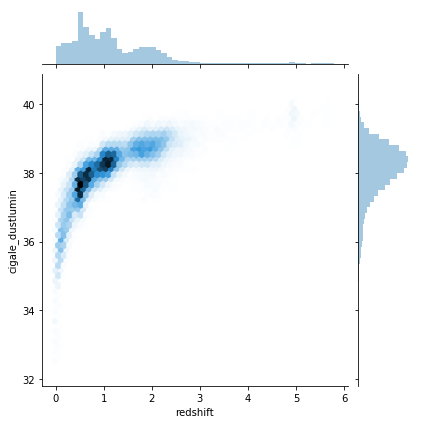

In [8]:
sns.jointplot(catalogue['redshift'], np.log10(catalogue['cigale_dustlumin']), kind="hex")#, color="#4CB391")

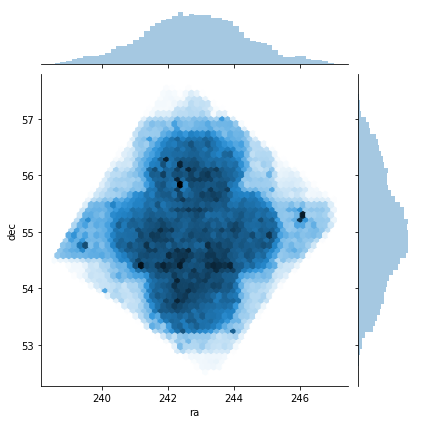

In [9]:
sns.jointplot(catalogue['ra'], catalogue['dec'], kind="hex")

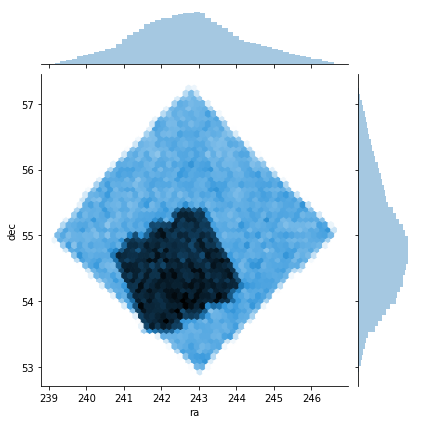

In [10]:
sns.jointplot(catalogue['ra'][~np.isnan(catalogue['f_irac_i1']) ], 
              catalogue['dec'][~np.isnan(catalogue['f_irac_i1']) ], kind="hex")

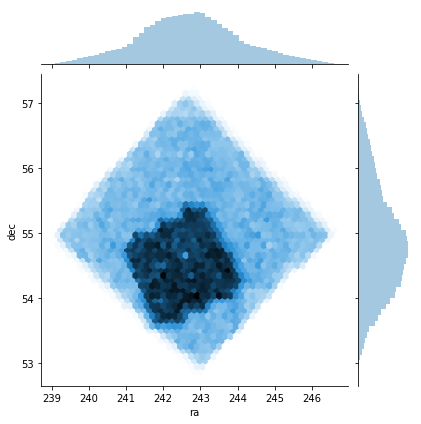

In [11]:
sns.jointplot(catalogue['ra'][~np.isnan(catalogue['f_mips_24']) ], 
              catalogue['dec'][~np.isnan(catalogue['f_mips_24']) ], kind="hex")

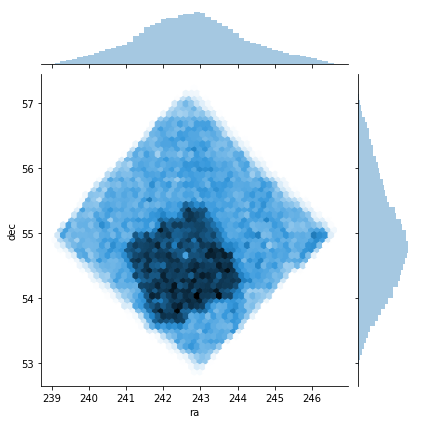

In [12]:
sns.jointplot(catalogue['ra'][catalogue['f_mips_24'] > 20. ], 
              catalogue['dec'][catalogue['f_mips_24'] > 20. ], kind="hex")

# Comparing Ldust prediction with Ldust

We also produced a prediction of Ldust for all 'good' (2+ optical and 2+ nir detections) objects with photo-z which should help us to characterise the selection

In [13]:
ldust_pred = Table.read(DMU_DIR + 'dmu28/dmu28_ELAIS-N1/data/'
                       +'ELAIS_N1_Ldust_prediction_results.fits')['id', 
                                           'bayes.dust.luminosity']
ldust_pred['bayes.dust.luminosity'].name = 'cigale_dustlumin_pred'
ldust_pred['cigale_dustlumin_pred'].fill_value = np.nan
ldust_pred = ldust_pred[~np.isnan(ldust_pred['cigale_dustlumin_pred'])]
ldust_pred['id'].name = 'help_id'
catalogue = join(catalogue, ldust_pred, join_type='left', keys='help_id')

catalogue['cigale_dustlumin_pred'].fill_value = np.nan
catalogue = catalogue.filled()

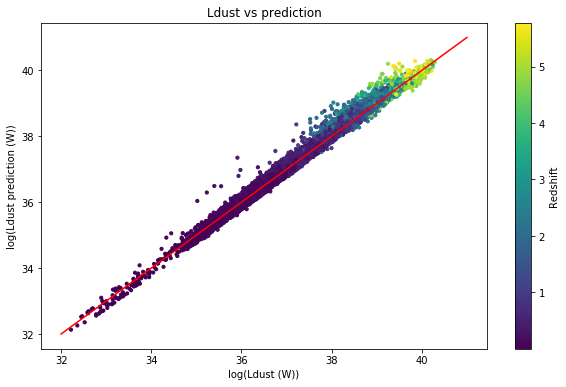

In [14]:
fig, axis = plt.subplots()

im = axis.scatter(np.log10(catalogue['cigale_dustlumin']),
            np.log10(catalogue['cigale_dustlumin_pred']), 
            s = 10, alpha=1, c=catalogue['redshift'])
fig.colorbar(im, ax=axis).set_label('Redshift')
axis.plot([32., 41],[32., 41], c='r')
axis.set_title('Ldust vs prediction')
axis.set_xlabel('log(Ldust (W))')
axis.set_ylabel('log(Ldust prediction (W))')

fig.set_size_inches(10, 6)
plt.show()
plt.savefig('Ldust_vs_pred.png')

In [15]:
## Kasia's XID full sample

In [16]:
xid_sample = Table.read(DMU_DIR + 'dmu28/dmu28_ELAIS-N1/data/'
                       +'zphot/xidsample/results.fits')['id', 
                                           'bayes.dust.luminosity']
xid_sample['bayes.dust.luminosity'].name = 'cigale_dustlumin_xid'
xid_sample['cigale_dustlumin_xid'].fill_value = np.nan
xid_sample = xid_sample[~np.isnan(xid_sample['cigale_dustlumin_xid'])]
xid_sample['id'].name = 'help_id'
catalogue = join(catalogue, xid_sample, join_type='left', keys='help_id')

catalogue['cigale_dustlumin_xid'].fill_value = np.nan
catalogue = catalogue.filled()

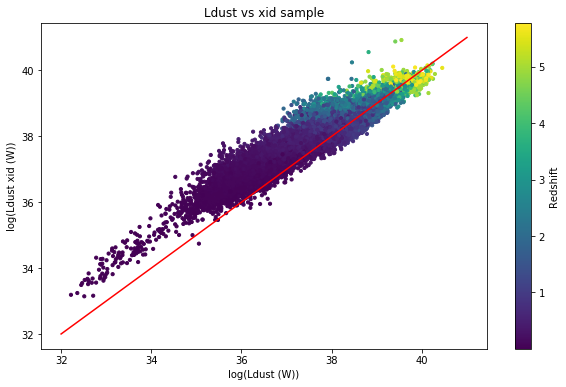

In [17]:
fig, axis = plt.subplots()

im = axis.scatter(np.log10(catalogue['cigale_dustlumin']),
            np.log10(catalogue['cigale_dustlumin_xid']), 
            s = 10, alpha=1, c=catalogue['redshift'])
fig.colorbar(im, ax=axis).set_label('Redshift')
axis.plot([32., 41],[32., 41], c='r')
axis.set_title('Ldust vs xid sample')
axis.set_xlabel('log(Ldust (W))')
axis.set_ylabel('log(Ldust xid (W))')

fig.set_size_inches(10, 6)
plt.show()
plt.savefig('Ldust_vs_xid.png')

# Simple LF as before

Without Vmax look at numbers. They are clearly too low. Will Vmax fix this?

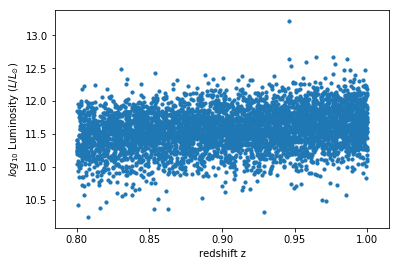

L_centre_values,dN_by_dL
float64,float64
2.152642592828666e+35,0.0
6.807253581629026e+35,0.0
2.152642592828666e+36,2.952546762520556e-07
6.807253581629026e+36,1.0629168345074e-05
2.152642592828666e+37,0.000196639614383869
6.807253581629027e+37,0.0008541717783971968
2.1526425928286657e+38,0.0003640490158187845
6.807253581629027e+38,1.4172224460098666e-05
2.1526425928286658e+39,2.952546762520556e-07


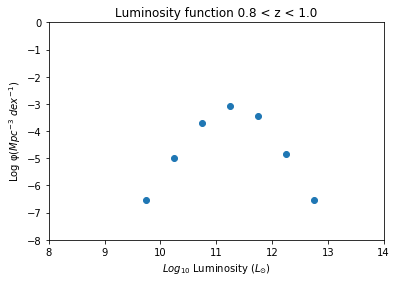

In [18]:
cosmo = FlatLambdaCDM(H0=100. , Om0 = (1-0.7))
#cosmo = Planck15

dV_z0  = cosmo.comoving_volume(0)
dV_z1  = cosmo.comoving_volume(1)
dV_z2  = cosmo.comoving_volume(2)


en1_moc = MOC(filename=DMU_DIR + 'dmu2/dmu2_field_coverages/'
                       +'ELAIS-N1_MOC.fits')

servs_moc = MOC(filename=DMU_DIR + 'dmu0/dmu0_DataFusion-Spitzer/data/'
                       +'DF-SERVS_ELAIS-N1_MOC.fits')
area = en1_moc.area

    
#plot_LF(0.8,1.,10**8.75 * Lsun, 10**14.25 * Lsun,catalogue, bin_width=0.5, 
#        show_sample=True, show_LF=True, vmax=True)
plot_LF(0.8,1.,10**8.75 * Lsun, 10**14.25 * Lsun,catalogue, bin_width=0.5, 
        show_sample=True, show_LF=True, vmax=False)
#plt.show()


#test = plot_LF(0.8,1.,10**8.75 * Lsun, 10**14.25 * Lsun,
#               grup_cat, bin_width=0.5, show_sample=True, show_LF=True, eff_area=True,
#              l_col='Lir')    

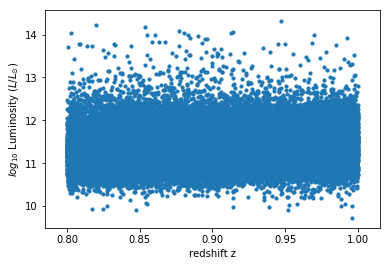

L_centre_values,dN_by_dL
float64,float64
1e+38,0.006999307355231229
1.7782794100389228e+38,0.003954050624367528
3.1622776601683792e+38,0.001960491050313649
5.623413251903491e+38,0.0008255320748007473
1e+39,nan


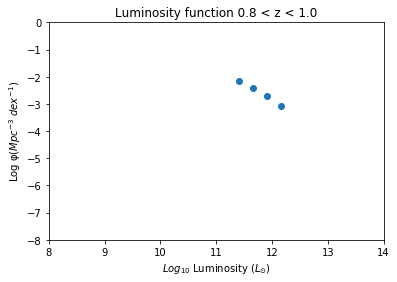

In [19]:
plot_LF(0.8,1.,10.**38,10.**39,catalogue, bin_width=0.25, 
        show_sample=True, show_LF=True, l_col='cigale_dustlumin_pred')

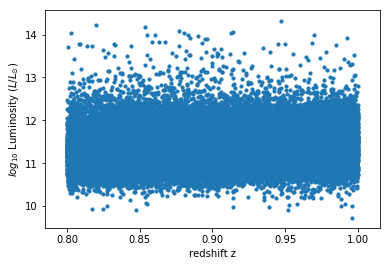

L_centre_values,dN_by_dL
float64,float64
1e+38,0.006999307355231229
1.7782794100389228e+38,0.003954050624367528
3.1622776601683792e+38,0.001960491050313649
5.623413251903491e+38,0.0008255320748007473
1e+39,nan


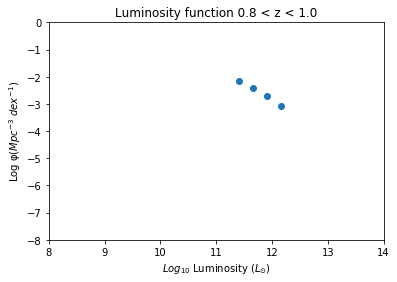

In [20]:
plot_LF(0.8,1.,10.**38,10.**39,catalogue, bin_width=0.25, 
        show_sample=True, show_LF=True, l_col='cigale_dustlumin_pred')

## The Grupioni total IR LF
![title](./Grupioni2013_fig6.png)

![title](./Grupioni2013_fig8.png)

In table 7 Grupioni gives modified Schechter function parameters. These will be useful for plotting comparisons to our data. The normal Schechter function is:

$$n(L) \  \mathrm{d}L = \phi^* \left(\frac{L}{L^*}\right)^\alpha \mathrm{e}^{-L/L^*} \frac{\mathrm{d}L}{L^*}$$

where $L$ is galaxy luminosity, and $L^*$ is a characteristic galaxy luminosity where the power-law form of the function cuts off. The parameter $\,\!\phi^*$ has units of number density and provides the normalization. The galaxy luminosity function may have different parameters for different populations and environments; it is not a universal function. One measurement from field galaxies is $\alpha=-1.25,\ \phi^* = 1.2 \times 10^{-2} h^3 \mathrm{Mpc}^{-3}$

The modifed Schechter function used by Gruppioni is:

$$n(L) \  \mathrm{dlog}L = \phi^* \left(\frac{L}{L^*}\right)^{(1-\alpha)} \mathrm{exp}\bigg[ - \frac{1}{2\sigma^2}\mathrm{log}^2 {(1+\frac{L}{L^*})}\bigg] \mathrm{dlog}L$$

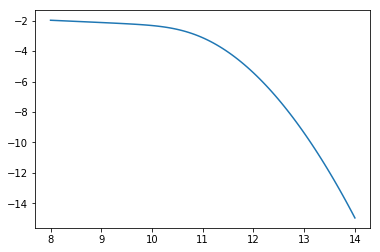

In [21]:
grup_schechter = [
    #zmin   zmax  alpha sigma L_s    L_s_err Phi_s Phi_s_err
    [0.0,   0.3,  1.15, 0.52, 10.12, 0.16,   -2.29, 0.06],
    [0.3,   0.45, 1.2,  0.5,  10.41, 0.03,   -2.31, 0.03],
    [0.45,  0.6,  1.2,  0.5,  10.55, 0.03,   -2.35, 0.05],
    [0.6,   0.8,  1.2,  0.5,  10.71, 0.03,   -2.35, 0.06],
    [0.8,   1.0,  1.2,  0.5,  10.97, 0.04,   -2.40, 0.05],
    [1.0,   1.2,  1.2,  0.5,  11.13, 0.04,   -2.43, 0.04],
    [1.2,   1.7,  1.2,  0.5,  11.37, 0.03,   -2.70, 0.04],
    [1.7,   2.0,  1.2,  0.5,  11.50, 0.03,   -3.00, 0.03],
    [2.0,   2.5,  1.2,  0.5,  11.60, 0.03,   -3.01, 0.11],
    [2.5,   3.0,  1.2,  0.5,  11.92, 0.08,   -3.27, 0.18],
    [3.0,   4.2,  1.2,  0.5,  11.90, 0.16,   -3.74, 0.30],
           ]

logL = np.linspace(8, 14, num=100)

def mod_schech(L, alpha, sigma, L_s, Phi_s):
    """Calculate \Phi(L) for an input array L, and modified Schechter params
    
    
    """
    
    phi = Phi_s * ((L/L_s)**(1-alpha)) * np.exp(- (1/(2*sigma**2)) * ((np.log10(1+(L/L_s)))**2) )
    return phi


plt.plot(logL, np.log10(mod_schech(10**logL, 
                       grup_schechter[0][2], 
                       grup_schechter[0][3], 
                       10**grup_schechter[0][4], 
                       10**grup_schechter[0][6])))

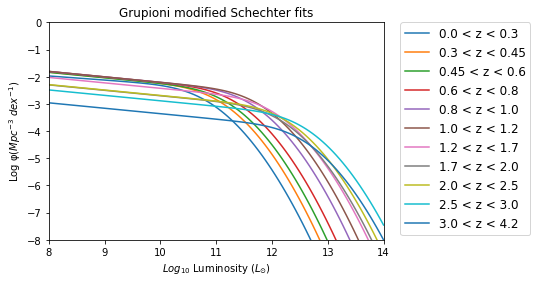

In [22]:
for dz in grup_schechter:
    #print('{} < z < {}'.format(dz[0], dz[1]))
    plt.plot(logL, np.log10(mod_schech(10**logL, 
                       dz[2], 
                       dz[3], 
                       10**dz[4], 
                       10**dz[6])),
            label ='{} < z < {}'.format(dz[0], dz[1]),
            )

    plt.ylim([-8.,0.])
    plt.xlim([8.,14.])
    
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1, fontsize=12)
plt.title('Grupioni modified Schechter fits')
plt.xlabel('$Log_{10}$ Luminosity ($L_{\odot}$)')
plt.ylabel('Log φ($Mpc^{-3}$ $dex^{-1}$)')

In [23]:
#The data points from figure 7
#Table 6: PEP total IR luminosity function
#log(LIR/L⊙) log(Φ/Mpc−3 dex−1)
#            0.0≤z<0.3       0.3≤z<0.45      0.45≤z<0.6      0.6≤z<0.8       0.8≤z<1.0       1.0≤z<1.2       1.2≤z<1.7       1.7≤z<2.0        2.0≤z<2.5       2.5≤z<3.0    3.0≤z<4.2
pep_lf = np.array([
[8.5,  9.0,  -2.21,  0.43,   np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
[9.0,  9.5,  -2.18,  0.09,   np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
[9.5,  10.0, -2.28,  0.04,   np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
[10.0, 10.5, -2.50,  0.03,   -2.37,  0.11,   np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
[10.5, 11.0, -2.71,  0.02,   -2.64,  0.04,   -2.61,  0.08,   -2.27,  0.15,   np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
[11.0, 11.5, -3.49,  0.06,   -3.12,  0.03,   -2.99,  0.04,   -2.89,  0.05,   -3.09,  0.08,   -2.80,  0.09,   -2.93,  0.18,   np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
[11.5, 12.0, -4.79,  0.25,   -4.29,  0.10,   -3.89,  0.05,   -3.53,  0.03,   -3.24,  0.04,   -3.17,  0.06,   -3.29,  0.06,   -3.76,  0.13,   np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
[12.0, 12.5, -5.27,  0.43,   -5.58,  0.43,   -5.50,  0.31,   -4.75,  0.09,   -4.23,  0.05,   -4.00,  0.03,   -3.81,  0.03,   -3.96,  0.11,   -3.53,   0.08,  -3.75,  0.21,   np.nan, np.nan],
[12.5, 13.0, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, -5.79,  0.31,   -5.74,  0.25,   -5.18,  0.12,   -4.85,  0.05,   -4.42,  0.04,   -4.40,   0.04,  -4.15,  0.11,   -4.65,  0.14  ],
[13.0, 13.5, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, -6.48,  0.31,   -6.01,  0.22,   -5.79,   0.13,  -5.11,  0.07,   -5.75,  0.13  ],
[13.5, 14.0, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, -6.54,   0.31,  -7.18,  0.43,   np.nan, np.nan]
])

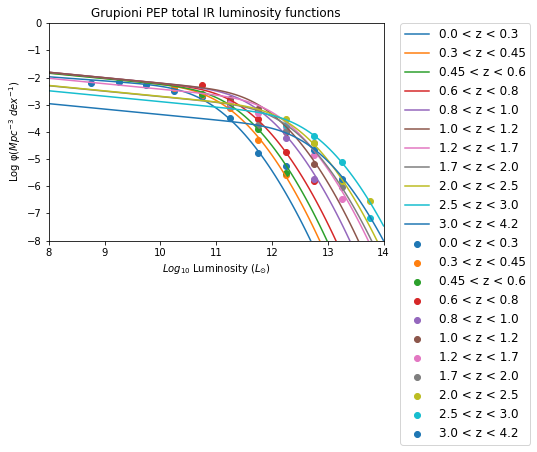

In [24]:
for n, dz in enumerate(grup_schechter):
    #print('{} < z < {}'.format(dz[0], dz[1]))

    col = 2 * n + 2
    plt.scatter(pep_lf[:,0] + 0.25, pep_lf[:,col],
            label ='{} < z < {}'.format(dz[0], dz[1]),
            )
    plt.plot(logL, np.log10(mod_schech(10**logL, 
                       dz[2], 
                       dz[3], 
                       10**dz[4], 
                       10**dz[6])),
            label ='{} < z < {}'.format(dz[0], dz[1]),
            )

    plt.ylim([-8.,0.])
    plt.xlim([8.,14.])
    
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1, fontsize=12)
plt.title('Grupioni PEP total IR luminosity functions')
plt.xlabel('$Log_{10}$ Luminosity ($L_{\odot}$)')
plt.ylabel('Log φ($Mpc^{-3}$ $dex^{-1}$)')

## Vmax

The simplest way to calculate Vmax is to assume selection is entirely dominated by our MIPS 20$\mu$Jy cut and compute Zmax for each galaxy ignoring K-corrections.

In [25]:
#Astropy has a function z_at_value which takes a function of z and a value and returns the z that gives that value

#from astropy.cosmology.funcs import luminosity_distance

def z_max(z_true, flux, cut=20):
    """Calculate redshift at which input flux is equal to cut"""
    lum_dist = cosmo.luminosity_distance(z_true)
    lum_dist_at_cut = np.sqrt((flux/cut)) * lum_dist
    z_max =  z_at_value( cosmo.luminosity_distance, lum_dist_at_cut)
    return z_max
    


In [26]:
#Test it seems sensible
%timeit z_max(1, 100.)

6.62 ms ± 948 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [27]:




try:
    zmax = Table.read('./data/vmax_product.fits')['help_id', 'z_max']
    catalogue = join(catalogue, zmax, join_type='left', keys='help_id')
except FileNotfoundError:
    catalogue.add_column(Column(data=np.full(len(catalogue), np.nan), name='z_max'))
    #catalogue.add_column(Column(data=np.full(len(catalogue), np.nan), name='v_max'))
    for gal in catalogue[~np.isnan(catalogue['f_mips_24']) 
                         & ~np.isnan(catalogue['redshift'])]:
        catalogue['z_max'][catalogue['help_id'] == gal['help_id']] = z_max(gal['redshift'], gal['f_mips_24']) 
    catalogue.write('./data/vmax_product.fits', overwrite=True)    

In [28]:
print('There are {} objects with f_mips_24 and {} with cigale Ldust measurements'.format(
    np.sum(~np.isnan(catalogue['f_mips_24'])),
    np.sum(~np.isnan(catalogue['cigale_dustlumin']))
))

There are 424717 objects with f_mips_24 and 49986 with cigale Ldust measurements


In [29]:
catalogue[~np.isnan(catalogue['z_max'])]

help_id,ra,dec,f_irac_i1,f_mips_24,redshift,cigale_dustlumin,cigale_dustlumin_pred,cigale_dustlumin_xid,z_max
,deg,deg,uJy,uJy,,W,,,
bytes27,float64,float64,float64,float64,float64,float64,float64,float64,float64
HELP_J155620.810+545113.308,239.086706815057,54.8536967354993,nan,272.37057,0.6999,nan,1.6327336680950252e+38,nan,2.0186323226851
HELP_J155622.752+545007.875,239.09480111705702,54.835520892499304,nan,269.6375,2.0693,nan,5.524172605939017e+39,nan,6.156766274896759
HELP_J155628.233+545746.644,239.11763696205702,54.962956684499304,nan,265.439,0.422,nan,8.014677688695553e+37,3.6966470325642823e+37,1.217670020853393
HELP_J155628.426+544936.570,239.118442949057,54.826824867499305,nan,275.15466,0.2276,nan,3.659035972346071e+37,nan,0.6923504210607795
HELP_J155628.601+545524.359,239.119170247057,54.9234330334993,nan,273.25345,0.585,nan,1.9590142278900115e+38,nan,1.6918351520033879
HELP_J155631.071+545619.623,239.12946352005702,54.9387842164993,nan,262.12546,6.4312,nan,nan,nan,20.075943749737387
HELP_J155631.108+545024.379,239.129617199057,54.8401052594993,nan,258.33447,0.1287,nan,nan,8.449032171546402e+36,0.3996058240212847
HELP_J155633.127+545753.634,239.138031185057,54.9648984454993,nan,280.96008,0.0748,nan,7.316343459816261e+35,nan,0.25144579381357307


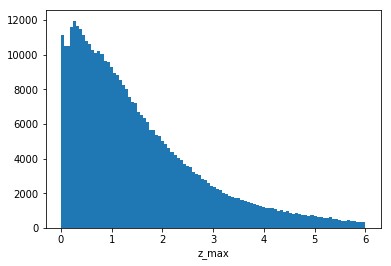

In [30]:
plt.hist(catalogue['z_max'][~np.isnan(catalogue['z_max'])], bins=100, range = (0,6))
plt.xlabel('z_max')

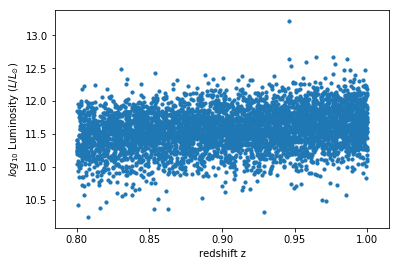

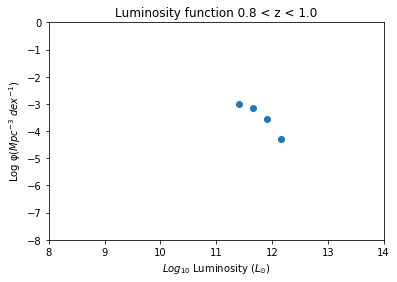

In [31]:
plot_LF(0.8,1.,10.**38,10.**39,catalogue, bin_width=0.25, show_sample=True, show_LF=True, vmax=True)
plt.show()

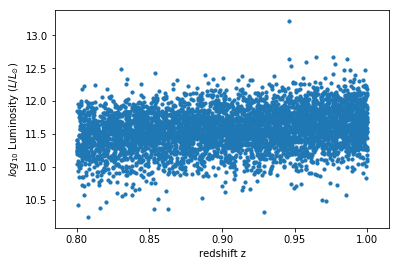

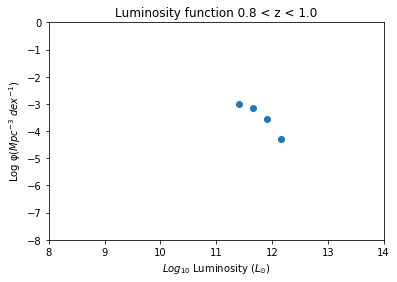

In [32]:
test = plot_LF(0.8,1.,10.**38,10.**39,catalogue, bin_width=0.25, show_sample=True, show_LF=True, vmax=True)

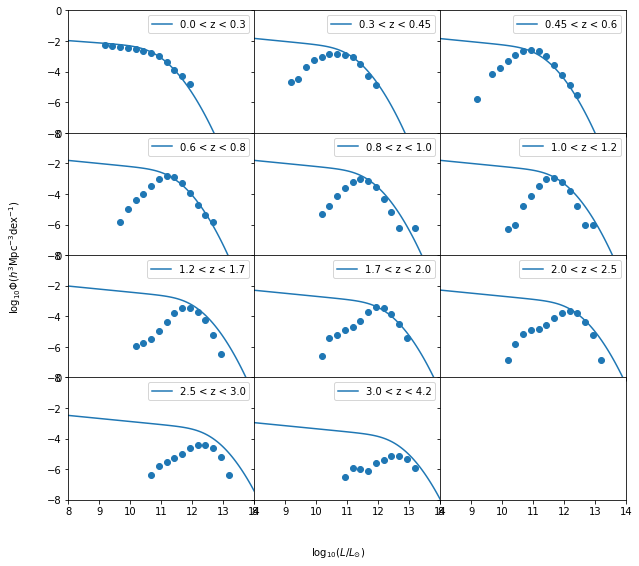

In [33]:
dim = [3,4]
fig, axes = plt.subplots(dim[1], dim[0], sharex=True, sharey=True)
#ax = fig.add_subplot(111)

for n, z_bin in enumerate(grup_schechter):
        
    x, y = np.floor_divide(n, dim[0]), np.remainder(n, dim[0])
    
    LF_tab = plot_LF(z_bin[0],z_bin[1],10.**35,10.**40,catalogue, bin_width=0.25, 
                     show_sample=False, show_LF=False, vmax=True, cosmo=cosmo)
    axes[x,y].scatter( np.log10(np.array(LF_tab['L_centre_values'])/Lsun), np.log10(np.array(LF_tab['dN_by_dL'])))
    

    axes[x,y].plot(logL, np.log10(mod_schech(10**logL, 
                       z_bin[2], 
                       z_bin[3], 
                       10**z_bin[4], 
                       10**z_bin[6])),
            label ='{} < z < {}'.format(z_bin[0], z_bin[1]),
            )

    axes[x,y].legend()
    
    axes[x,y].set_ylim([-8.0,0.])
    axes[x,y].set_xlim([8.,14.])
    
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1, fontsize=12)
#plt.rc('text', usetex=True)
fig.set_size_inches(10, 9)
fig.subplots_adjust(hspace=0, wspace=0)
#axes[0,0].set_title('Grupioni modified Schechter fits')
#fig.xlabel('$Log_{10}$ Luminosity ($L_{\odot}$)')
#fig.ylabel('Log φ($Mpc^{-3}$ $dex^{-1}$)')
fig.text(0.5, 0.04, 'log$_{10} (L/L_{\odot})$', ha='center')
fig.text(0.04, 0.5, 'log$_{10} \Phi(h^3 $Mpc$^{-3} $dex$^{-1})$', va='center', rotation='vertical')
fig.show()

In [34]:
catalogue.colnames

['help_id',
 'ra',
 'dec',
 'f_irac_i1',
 'f_mips_24',
 'redshift',
 'cigale_dustlumin',
 'cigale_dustlumin_pred',
 'cigale_dustlumin_xid',
 'z_max']

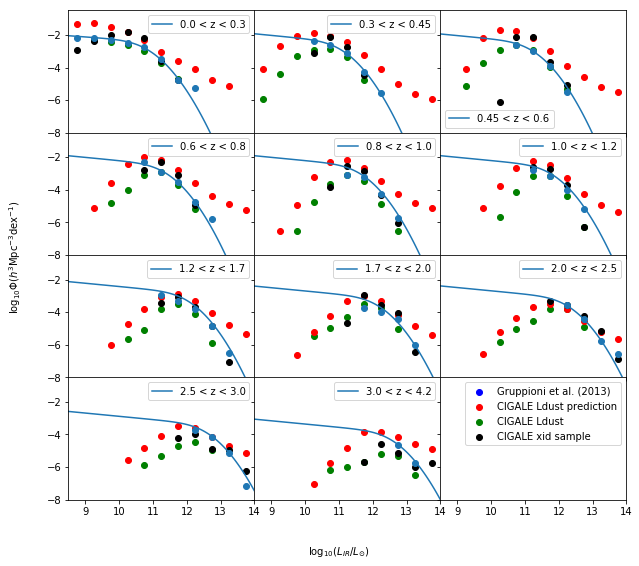

In [58]:
dim = [3,4]
fig, axes = plt.subplots(dim[1], dim[0], sharex=True, sharey=True)
#ax = fig.add_subplot(111)

for n, z_bin in enumerate(grup_schechter):
        
    L1, L2 = 10**8.75 * Lsun, 10**14.25 * Lsun
    bin_width=0.5
    
    
    x, y = np.floor_divide(n, dim[0]), np.remainder(n, dim[0])
    
    #Compute LF for XID+ sample
    LF_tab = plot_LF(z_bin[0],z_bin[1],L1,L2,catalogue, bin_width=bin_width, 
                     show_sample=False, show_LF=False, vmax=True)
    axes[x,y].scatter( np.log10(np.array(LF_tab['L_centre_values'])/Lsun), 
                      np.log10(np.array(LF_tab['dN_by_dL'])),
                     c='g')
    
    #Compute LF for L_dust_pred sample
    LF_tab_pred = plot_LF(z_bin[0],z_bin[1],L1,L2,catalogue, bin_width=bin_width, 
                     show_sample=False, show_LF=False, vmax=False,
                     l_col='cigale_dustlumin_pred')
    axes[x,y].scatter( np.log10(np.array(LF_tab_pred['L_centre_values'])/Lsun), 
                      np.log10(np.array(LF_tab_pred['dN_by_dL'])),
                     c='r')
    
    #Compute LF for full xid sample
    LF_tab_pred = plot_LF(z_bin[0],z_bin[1],L1,L2,catalogue, bin_width=bin_width, 
                     show_sample=False, show_LF=False, vmax=False,
                     l_col='cigale_dustlumin_xid')
    axes[x,y].scatter( np.log10(np.array(LF_tab_pred['L_centre_values'])/Lsun), 
                      np.log10(np.array(LF_tab_pred['dN_by_dL'])),
                     c='k')

    #Gruppioni bins
    col = 2 * n + 2
    axes[x,y].scatter(pep_lf[:,0] + 0.25, pep_lf[:,col],
            #label ='{} < z < {}'.format(dz[0], dz[1]),
            )
    
    #Gruppioni Schechter fits
    axes[x,y].plot(logL, np.log10(mod_schech(10**logL, 
                       z_bin[2], 
                       z_bin[3], 
                       10**z_bin[4], 
                       10**z_bin[6])),
            label ='{} < z < {}'.format(z_bin[0], z_bin[1]),
            )

    axes[x,y].legend()
    
    axes[x,y].set_ylim([-8.,-0.5])
    axes[x,y].set_xlim([8.5,14.])
    
if True:
    axes[3,2].scatter([-10],[-10],
            label ='Gruppioni et al. (2013)',
                      c='b'
            )
    axes[3,2].scatter([-10],[-10],
            label ='CIGALE Ldust prediction',
                      c='r'
            )
    axes[3,2].scatter([-10],[-10],
            label ='CIGALE Ldust',
                      c='g'
            )
    axes[3,2].scatter([-10],[-10],
            label ='CIGALE xid sample',
                      c='k'
            )
    axes[3,2].legend()
    
    axes[3,2].set_ylim([-8.,-0.5])
    axes[3,2].set_xlim([8.5,14.])
    
#plt.setp(axes, xticks=[0.1, 0.5, 0.9], 
#        yticks=[1, 2, 3])

#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1, fontsize=12)
#plt.rc('text', usetex=True)
fig.set_size_inches(10, 9)
fig.subplots_adjust(hspace=0, wspace=0)
#axes[0,0].set_title('Grupioni modified Schechter fits')
#fig.xlabel('$Log_{10}$ Luminosity ($L_{\odot}$)')
#fig.ylabel('Log φ($Mpc^{-3}$ $dex^{-1}$)')
fig.text(0.5, 0.04, 'log$_{10} (L_{IR}/L_{\odot})$', ha='center')
fig.text(0.04, 0.5, 'log$_{10} \Phi(h^3 $Mpc$^{-3} $dex$^{-1})$', va='center', rotation='vertical')
fig.show()
plt.savefig('./figs/LF_xid_en1.png', bbox_inches='tight')
plt.savefig('./figs/LF_xid_en1.pdf', bbox_inches='tight')

In [36]:
plot_LF(0,0.3,10**9.5 * Lsun, 10**14.5 * Lsun,catalogue, bin_width=bin_width, 
                     show_sample=False, show_LF=False, vmax=True)

L_centre_values,dN_by_dL
float64,float64
1.2105198883124609e+36,0.0038793215101522896
3.828000000000017e+36,0.00302109370087351
1.210519888312461e+37,0.0016863755422789031
3.828000000000017e+37,0.0005214686833125068
1.210519888312461e+38,5.4891440348684904e-05
3.828000000000017e+38,4.990130940789538e-06
1.210519888312461e+39,nan
3.828000000000017e+39,nan
1.210519888312461e+40,nan


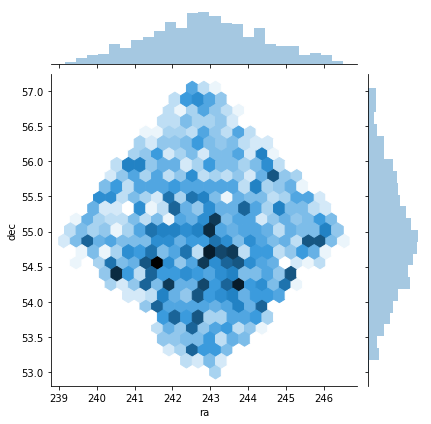

In [37]:
mask_z0p6_0p8_L_10_10p5 = ((catalogue['redshift'] < 0.8 )
                           &(catalogue['redshift'] < 0.6 )
                           &(catalogue['cigale_dustlumin'] < Lsun * 10**10.5 )
                           &(catalogue['cigale_dustlumin'] > Lsun * 10**10.0 ))
sns.jointplot(catalogue['ra'][mask_z0p6_0p8_L_10_10p5 ], 
              catalogue['dec'][mask_z0p6_0p8_L_10_10p5], kind="hex")

# COSMOS
Let us look at the COSMOS field where the prior list may have been simpler.

In [38]:
#Made a small subcat with: 
#stilts tpipe cmd='keepcols "help_id ra dec f_irac_i1 f_mips_24 redshift cigale_dustlumin"' 
#COSMOS_20180619.fits omode=out out=cut_for_lf.fits
cosmos_cat = Table.read(DMU_DIR + 'dmu32/dmu32_COSMOS/data/'
                       +'cut_for_lf.fits')['help_id',
                                           'ra', 
                                           'dec', 
                                           'f_irac_i1', 
                                           'f_mips_24',
                                           'redshift', 
                                           'cigale_dustlumin'] #ELAIS-N1_20171016.fits

In [39]:
cosmos_moc = MOC(filename=DMU_DIR + 'dmu0/dmu0_COSMOS2015/data/'
                       +'COSMOS2015-HELP_selected_20160613_MOC.fits')
cosmos_area = cosmos_moc.area

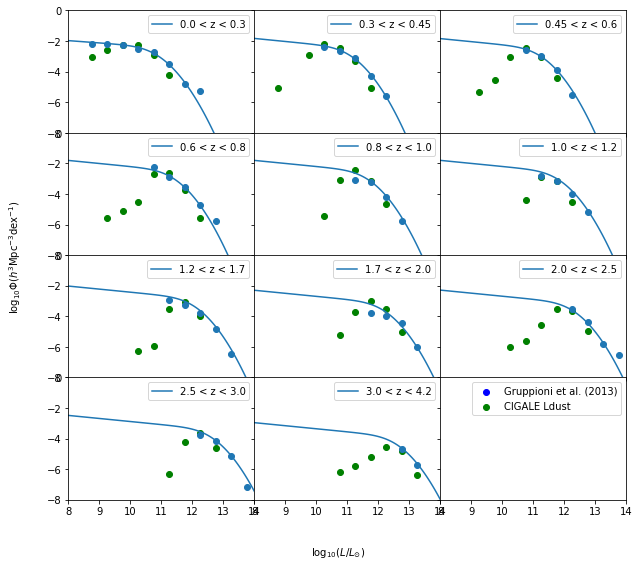

In [40]:
dim = [3,4]
fig, axes = plt.subplots(dim[1], dim[0], sharex=True, sharey=True)
#ax = fig.add_subplot(111)

for n, z_bin in enumerate(grup_schechter):
        
    L1, L2 = 10**8.75 * Lsun, 10**14.25 * Lsun
    bin_width=0.5
    
    
    x, y = np.floor_divide(n, dim[0]), np.remainder(n, dim[0])
    
    #Compute LF for XID+ sample
    LF_tab = plot_LF(z_bin[0],z_bin[1],L1,L2,cosmos_cat, bin_width=bin_width, 
                     show_sample=False, show_LF=False, vmax=False, moc=cosmos_moc)
    axes[x,y].scatter( np.log10(np.array(LF_tab['L_centre_values'])/Lsun), 
                      np.log10(np.array(LF_tab['dN_by_dL'])),
                     c='g')
    

    #Gruppioni bins
    col = 2 * n + 2
    axes[x,y].scatter(pep_lf[:,0] + 0.25, pep_lf[:,col],
            #label ='{} < z < {}'.format(dz[0], dz[1]),
            )
    
    #Gruppioni Schechter fits
    axes[x,y].plot(logL, np.log10(mod_schech(10**logL, 
                       z_bin[2], 
                       z_bin[3], 
                       10**z_bin[4], 
                       10**z_bin[6])),
            label ='{} < z < {}'.format(z_bin[0], z_bin[1]),
            )

    axes[x,y].legend()
    
    axes[x,y].set_ylim([-8.,0.])
    axes[x,y].set_xlim([8.,14.])
    
if True:
    axes[3,2].scatter([-10],[-10],
            label ='Gruppioni et al. (2013)',
                      c='b'
            )

    axes[3,2].scatter([-10],[-10],
            label ='CIGALE Ldust',
                      c='g'
            )
    axes[3,2].legend()
    
    axes[3,2].set_ylim([-8.,0.])
    axes[3,2].set_xlim([8.,14.])
    
    
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1, fontsize=12)
#plt.rc('text', usetex=True)
fig.set_size_inches(10, 9)
fig.subplots_adjust(hspace=0, wspace=0)
#axes[0,0].set_title('Grupioni modified Schechter fits')
#fig.xlabel('$Log_{10}$ Luminosity ($L_{\odot}$)')
#fig.ylabel('Log φ($Mpc^{-3}$ $dex^{-1}$)')
fig.text(0.5, 0.04, 'log$_{10} (L/L_{\odot})$', ha='center')
fig.text(0.04, 0.5, 'log$_{10} \Phi(h^3 $Mpc$^{-3} $dex$^{-1})$', va='center', rotation='vertical')
fig.show()

In [41]:
grup_cat = Table.read('./data/cosmos_160um_0.8-1_pos24.fits')

In [42]:
grup_cat['z'].name = 'redshift'
grup_cat.add_column(Column(data=np.full(len(grup_cat), np.nan), name='Lir', dtype='float64'))
grup_cat['Lir'] = Lsun * 10 ** grup_cat['LogLir']

In [43]:
grup_cat

ID,redshift,f_FUV,f_NUV f,_B,f_g,f_V,f_R,f_i,f_z,f_J,f_K,f_3.6,f_4.5,f_5.8,f_8.0,f_24,f_100,f_160,f_250,f_350,f_500,LogLir,eff_area,id24,ra24,dec24,Lir
int16,float32,float32,float32,float32,float32,bytes10,float32,float32,float32,float32,float32,bytes8,float32,float32,float32,float32,int32,int32,int32,int32,int32,float32,float32,int32,float64,float64,float32
41,0.92,0.0,0.3148,0.3474,0.52,1.175,2.777,9.179,18.5,43.17,136.4,167,134.6,113.7,109.8,727.1,49800,106300,74470,47600,38190,12.5,2.04,38696,149.933008,2.558845,inf
56,0.95,1.876,4.479,4.952,5.546,6.564,8.076,15.56,21.26,38.83,61.89,86.46,84.41,96.74,241.0,1727.0,77480,97630,61150,29950,0,12.64,2.04,50319,150.769797,1.564333,inf
62,0.84,0.4898,1.692,2.017,2.471,4.521,7.77,24.77,43.29,74.61,192.8,235.5,313.9,508.2,1471.0,4639.0,63680,95320,70400,41920,12820,12.48,2.04,51496,150.722208,2.039591,inf
114,0.9,0.0,0.5776,0.62,0.7635,1.097,1.738,4.223,6.415,12.31,31.45,59.43,48.39,52.24,56.75,841.8,48800,74470,52380,30390,0,12.4,2.04,51857,150.149444,2.59561,inf
150,0.92,0.0,0.1393,0.153,0.1975,0.326,0.6989,2.158,4.007,9.854,38.19,78.85,65.22,74.68,93.76,635.0,39410,67670,49290,38980,18230,12.4,2.04,51033,150.492919,2.584734,inf
201,0.86,0.08091,0.2669,0.3119,0.4014,0.9129,1.738,5.927,10.53,21.4,60.87,88.31,68.17,57.28,65.34,587.8,31100,60420,54150,37770,18100,12.18,2.04,32860,149.716677,2.705699,inf
202,0.95,0.5277,2.592,2.742,3.082,3.688,4.639,8.766,12.16,21.98,38.73,60.93,52.34,61.26,104.6,735.9,41110,60310,39990,22000,0,12.36,2.04,13611,149.771126,1.990267,inf
206,0.92,0.0,0.3221,0.4313,0.5375,0.9462,1.795,5.385,9.854,24.3,76.21,108,92.3,76.63,75.37,592.1,18400,59590,65520,53600,27060,12.27,2.04,11923,150.487236,1.830812,inf
240,0.89,0.0,0.4361,0.51,0.5302,0.8511,1.363,3.545,5.649,11.87,40.36,70.15,60.09,60.53,82.26,562.9,31390,56810,40890,27800,19860,12.23,2.04,47281,150.15915,2.191273,inf


(array([ 12.,   7.,   9.,   9.,  81.,  80.,  98.,  47.,  36., 105.]),
 array([0.45      , 0.60899997, 0.768     , 0.927     , 1.086     ,
        1.245     , 1.4039999 , 1.563     , 1.722     , 1.8809999 ,
        2.04      ], dtype=float32),
 <a list of 10 Patch objects>)

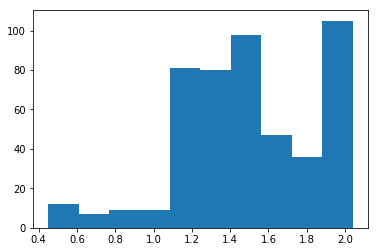

In [44]:
plt.hist(grup_cat['eff_area'])

(array([51., 59., 75., 54., 20., 36., 73., 45., 32., 39.]),
 array([0.8       , 0.819     , 0.838     , 0.857     , 0.876     ,
        0.895     , 0.91400003, 0.933     , 0.952     , 0.971     ,
        0.99      ], dtype=float32),
 <a list of 10 Patch objects>)

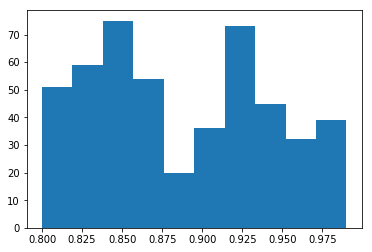

In [45]:
plt.hist(grup_cat['redshift'])

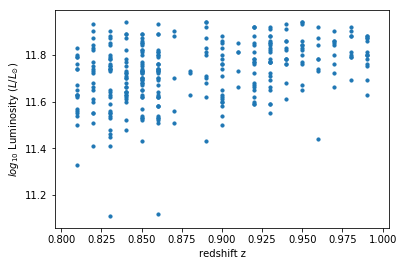

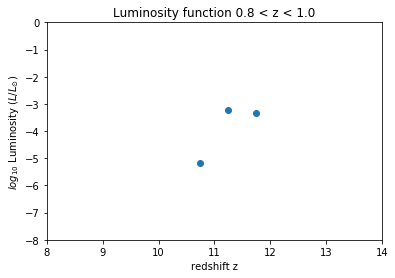

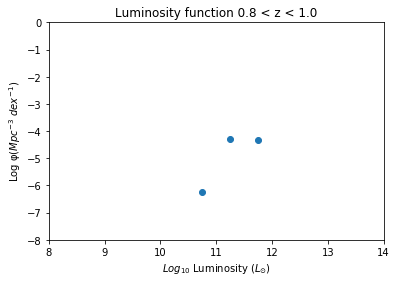

In [46]:
test = plot_LF(0.8,1.,10**8.75 * Lsun, 10**14.25 * Lsun,
               grup_cat, bin_width=0.5, show_sample=True, show_LF=True, eff_area=True,
              l_col='Lir')

test2 = plot_LF(0.8,1.,10**8.75 * Lsun, 10**14.25 * Lsun,
               grup_cat, bin_width=0.5, show_sample=True, show_LF=True, eff_area=False,
              l_col='Lir')

(8.0, 14.0)

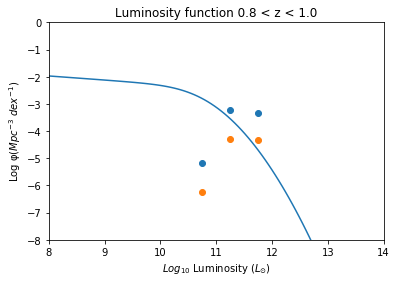

In [47]:
plt.scatter( np.log10(np.array(test['L_centre_values'])/Lsun), np.log10(np.array(test['dN_by_dL'])))
        #plt.xscale('log')
plt.scatter( np.log10(np.array(test2['L_centre_values'])/Lsun), np.log10(np.array(test2['dN_by_dL'])))

plt.plot(logL, np.log10(mod_schech(10**logL, 
                       grup_schechter[0][2], 
                       grup_schechter[0][3], 
                       10**grup_schechter[0][4], 
                       10**grup_schechter[0][6])))
plt.title('Luminosity function {} < z < {}'.format(0.8, 1.0))
plt.xlabel('$Log_{10}$ Luminosity ($L_{\odot}$)')
plt.ylabel('Log φ($Mpc^{-3}$ $dex^{-1}$)')
plt.ylim([-8.,0.])
plt.xlim([8.,14.])

It seems as though the effective area which presumably is a representation of the Vmax method brings their number counts up. Lets lookt at the area distribution of our points and the number dropoffs at each selection stage.

In [48]:
z_test = np.linspace(0.8, 1., num=100)

In [49]:
v_test = volume(0.8,z_test,cosmo)

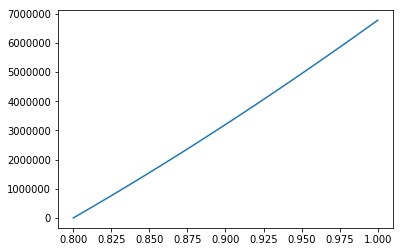

In [50]:
plt.plot(z_test, v_test)

In [51]:
z_test2 = np.linspace(0, 4., num=100)

In [52]:
v_test2 = volume(0.8,z_test2,cosmo)

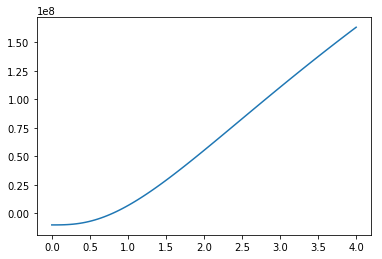

In [53]:
plt.plot(z_test2, v_test2)

(array([226., 168.,  58.,   7.,  10.,   0.,   3.,   3.,   8.,   1.]),
 array([1.0229212, 1.3843534, 1.7457856, 2.1072178, 2.46865  , 2.8300822,
        3.1915145, 3.5529466, 3.914379 , 4.275811 , 4.6372433],
       dtype=float32),
 <a list of 10 Patch objects>)

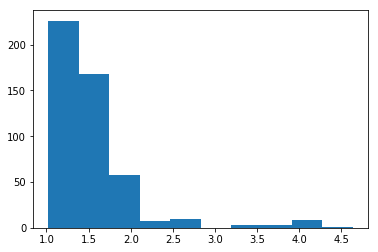

In [54]:
plt.hist(cosmos_moc.area_sq_deg/grup_cat['eff_area'])

In [55]:
np.mean(cosmos_moc.area_sq_deg/grup_cat['eff_area'])

1.5101999

In [56]:
np.sum(np.array([True, True, False, False]) * np.array([1,4,7,8]) )

5